#Smart Parking Space Detector

In [1]:
print("🚀 Starting Smart Parking Detector Setup...")

# Mount Google Drive for persistent storage
from google.colab import drive
import os

print("📁 Mounting Google Drive...")
drive.mount('/content/drive')

# Create project directory in Drive for persistence
PROJECT_DIR = '/content/drive/MyDrive/SmartParkingProject'
os.makedirs(PROJECT_DIR, exist_ok=True)
print(f"✅ Project directory created: {PROJECT_DIR}")




🚀 Starting Smart Parking Detector Setup...
📁 Mounting Google Drive...
Mounted at /content/drive
✅ Project directory created: /content/drive/MyDrive/SmartParkingProject


In [2]:
# Install required packages
print("📦 Installing dependencies...")
!pip install -q ultralytics roboflow supervision
!pip install -q torch torchvision torchaudio
!pip install -q opencv-python matplotlib pandas numpy tqdm
!pip install -q streamlit gradio
!pip install -q scikit-learn seaborn

print("✅ All dependencies installed!")

📦 Installing dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 117.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

# ====================================================================
# TASK 1: Dataset Download and Verification
# ====================================================================

In [4]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import random
import time
import urllib.request
import zipfile
import tarfile
import shutil
from tqdm import tqdm

print("\n" + "="*60)
print("TASK 1: DATASET DOWNLOAD & VERIFICATION")
print("="*60)

# Dataset URLs (update these with actual URLs if different)
DATASETS = {
    'patches_main': 'https://github.com/fabiocarrara/deep-parking/releases/download/archive/CNRPark-Patches-150x150.zip',
    'patches_ext': 'https://github.com/fabiocarrara/deep-parking/releases/download/archive/CNR-EXT-Patches-150x150.zip',
    'full_images': 'https://github.com/fabiocarrara/deep-parking/releases/download/archive/CNR-EXT_FULL_IMAGE_1000x750.tar'
}

# Download paths
DOWNLOAD_DIR = Path('/content/downloads')
DOWNLOAD_DIR.mkdir(exist_ok=True)

def download_dataset(url, filename):
    """Download dataset with progress bar"""
    filepath = DOWNLOAD_DIR / filename
    if filepath.exists():
        print(f" {filename} already exists, skipping download")
        return filepath

    print(f" Downloading {filename}...")

    def progress_hook(block_num, block_size, total_size):
        downloaded = block_num * block_size
        percent = min(100, (downloaded / total_size) * 100)
        bar_length = 50
        filled_length = int(bar_length * percent / 100)
        bar = '█' * filled_length + '-' * (bar_length - filled_length)
        print(f'\r|{bar}| {percent:.1f}% ({downloaded/1024/1024:.1f}MB/{total_size/1024/1024:.1f}MB)', end='')

    try:
        urllib.request.urlretrieve(url, filepath, progress_hook)
        print(f"\ Downloaded: {filename}")
        return filepath
    except Exception as e:
        print(f"\n Failed to download {filename}: {e}")
        return None

# Download all datasets
print(" Starting dataset downloads...")

# Download patch datasets for CNN training
patches_main_path = download_dataset(DATASETS['patches_main'], 'CNRPark-Patches-150x150.zip')
patches_ext_path = download_dataset(DATASETS['patches_ext'], 'CNR-EXT-Patches-150x150.zip')

# Download full images for YOLO training
full_images_path = download_dataset(DATASETS['full_images'], 'CNR-EXT_FULL_IMAGE_1000x750.tar')

print("\n All downloads completed!")


TASK 1: DATASET DOWNLOAD & VERIFICATION
 Starting dataset downloads...
|██████████████████████████████████████████████████| 100.0% (34.9MB/34.9MB)\ Downloaded: CNRPark-Patches-150x150.zip
|██████████████████████████████████████████████████| 100.0% (428.7MB/428.7MB)\ Downloaded: CNR-EXT-Patches-150x150.zip
|██████████████████████████████████████████████████| 100.0% (1053.2MB/1053.2MB)\ Downloaded: CNR-EXT_FULL_IMAGE_1000x750.tar

 All downloads completed!


In [ ]:
# Extract datasets
print("\n📂 Extracting datasets...")

# Extract patches
if patches_main_path and patches_main_path.exists():
    print(" Extracting main patches...")
    with zipfile.ZipFile(patches_main_path, 'r') as zip_ref:
        zip_ref.extractall('/content/patches_main')
    print("✅ Main patches extracted")

if patches_ext_path and patches_ext_path.exists():
    print(" Extracting extended patches...")
    with zipfile.ZipFile(patches_ext_path, 'r') as zip_ref:
        zip_ref.extractall('/content/patches_ext')
    print("✅ Extended patches extracted")

# Extract full images
if full_images_path and full_images_path.exists():
    print(" Extracting full images...")
    with tarfile.open(full_images_path, 'r') as tar_ref:
        tar_ref.extractall('/content/')
    print("✅ Full images extracted")


 Verifying dataset structure...
 Main Patches Dataset:
   Camera A: 2550 free, 3621 occupied
   Camera B: 1632 free, 4781 occupied
 Main Total: 4182 free + 8402 occupied = 12584 patches

 Extended Patches Dataset:
 Extended Total (estimated): 188773 free + 239360 occupied = 428133 patches

 Full Images Dataset:
   Camera 1: 459 images
   Camera 2: 464 images
   Camera 3: 460 images
   Camera 4: 457 images
   Camera 5: 474 images
   Camera 6: 495 images
   Camera 7: 495 images
   Camera 8: 484 images
   Camera 9: 490 images
 Total: 4278 full images
 Found 9 CSV annotation files

 TOTAL ESTIMATED PATCHES: 440,717

 COMPUTE OPTIMIZATION RECOMMENDATIONS:
  LARGE DATASET !

 Displaying sample images...


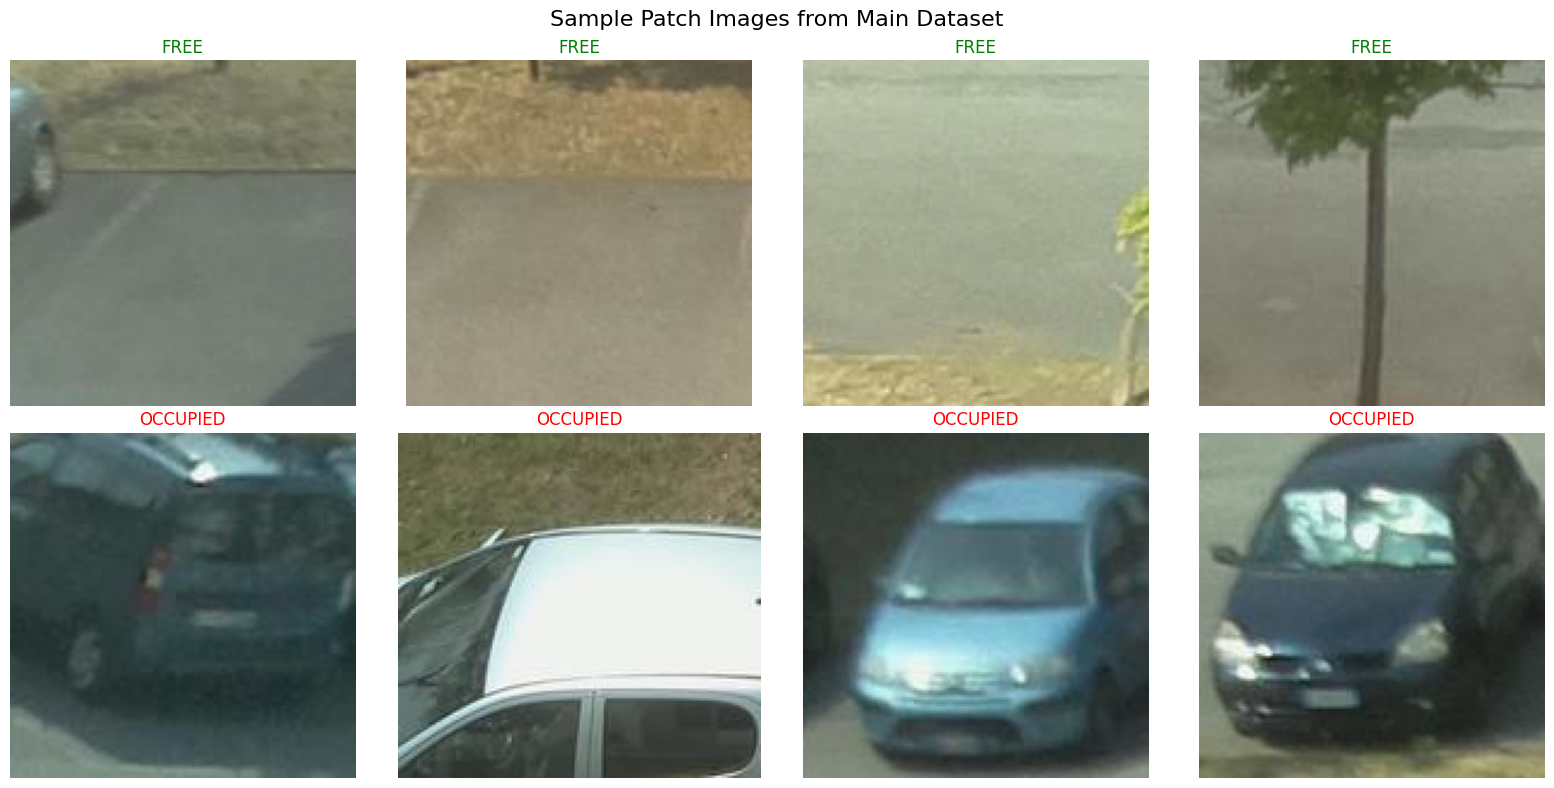

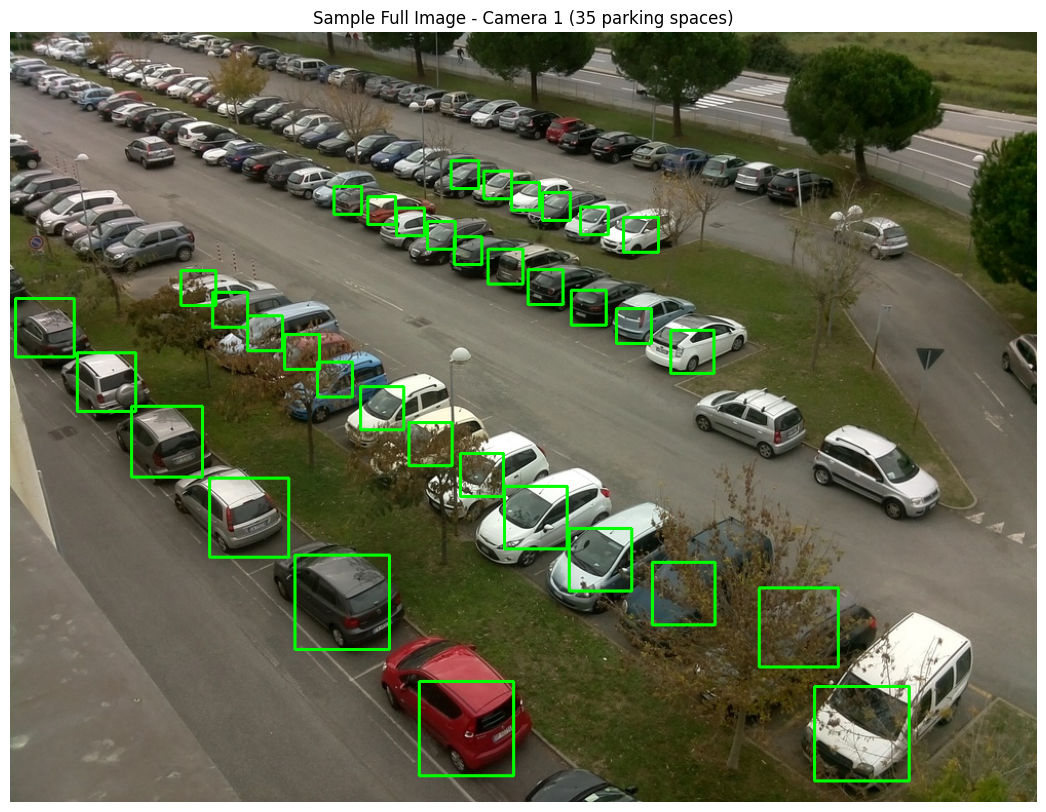

 TASK 1 COMPLETED: Dataset verification successful!
 Dataset info saved to: /content/drive/MyDrive/SmartParkingProject/dataset_info.json


In [11]:
# Verify and count datasets
print("\n Verifying dataset structure...")

def verify_main_patches():
    """Verify main patches dataset (A/B structure)"""
    base_path = Path('/content/patches_main')
    if not base_path.exists():
        return 0, 0

    total_free = 0
    total_occupied = 0

    for camera in ['A', 'B']:
        camera_path = base_path / camera
        if camera_path.exists():
            free_count = len(list((camera_path / 'free').glob('*.jpg'))) if (camera_path / 'free').exists() else 0
            busy_count = len(list((camera_path / 'busy').glob('*.jpg'))) if (camera_path / 'busy').exists() else 0

            total_free += free_count
            total_occupied += busy_count

            if free_count > 0 or busy_count > 0:
                print(f"   Camera {camera}: {free_count} free, {busy_count} occupied")

    return total_free, total_occupied

def verify_extended_patches():
    """Verify extended patches dataset (weather-based structure)"""
    base_path = Path('/content/patches_ext')
    if not base_path.exists():
        return 0, 0

    # Check if LABELS folder exists
    labels_dir = base_path / 'LABELS'
    patches_dir = base_path / 'PATCHES'

    if not labels_dir.exists() or not patches_dir.exists():
        print("  ❌ Expected LABELS and PATCHES folders not found")
        return 0, 0

    # Count label entries
    label_files = list(labels_dir.glob('*.txt'))
    total_labels = 0
    free_labels = 0
    occupied_labels = 0

    for label_file in label_files[:3]:  # Check first 3 label files only
        try:
            with open(label_file, 'r') as f:
                lines = f.readlines()

            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 2:
                    label = int(parts[1])
                    total_labels += 1
                    if label == 0:
                        free_labels += 1
                    else:
                        occupied_labels += 1
        except:
            continue

    # Estimate total from sample
    total_label_files = len(label_files)
    if total_label_files > 3:
        # Scale up the estimate
        scale_factor = total_label_files / 3
        free_labels = int(free_labels * scale_factor)
        occupied_labels = int(occupied_labels * scale_factor)

    return free_labels, occupied_labels

def verify_full_images():
    """Verify full images dataset"""
    full_images_dir = Path('/content/FULL_IMAGE_1000x750')
    if not full_images_dir.exists():
        return 0, 0

    total_images = 0
    csv_count = 0

    # Count images per camera (limit to avoid long processing)
    for i in range(1, 10):
        camera_images = list(full_images_dir.glob(f'**/camera{i}/*.jpg'))
        if camera_images:
            print(f"   Camera {i}: {len(camera_images)} images")
            total_images += len(camera_images)

    # Check CSV files
    csv_files = list(Path('/content/').glob('camera*.csv'))
    csv_count = len(csv_files)

    return total_images, csv_count

# Run verification
print(" Main Patches Dataset:")
main_free, main_occupied = verify_main_patches()
print(f" Main Total: {main_free} free + {main_occupied} occupied = {main_free + main_occupied} patches")

print("\n Extended Patches Dataset:")
ext_free, ext_occupied = verify_extended_patches()
print(f" Extended Total (estimated): {ext_free} free + {ext_occupied} occupied = {ext_free + ext_occupied} patches")

print("\n Full Images Dataset:")
total_images, csv_count = verify_full_images()
print(f" Total: {total_images} full images")
print(f" Found {csv_count} CSV annotation files")

# Calculate total dataset size
total_patches = main_free + main_occupied + ext_free + ext_occupied
print(f"\n TOTAL ESTIMATED PATCHES: {total_patches:,}")

# Memory and compute optimization recommendations
print(f"\n COMPUTE OPTIMIZATION RECOMMENDATIONS:")

if total_patches > 50000:
    print("  LARGE DATASET !")

recommended_subset = min(total_patches, 25000)  # Limit to 25k patches for training

# Show sample images
print("\n Displaying sample images...")

def show_sample_patches():
    """Display sample patches from main dataset"""
    base_path = Path('/content/patches_main')
    if not base_path.exists():
        print("❌ Main patches not available for display")
        return

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Sample Patch Images from Main Dataset', fontsize=16)

    # Get sample images from camera A
    camera_a = base_path / 'A'
    if camera_a.exists():
        free_images = list((camera_a / 'free').glob('*.jpg'))[:4]
        busy_images = list((camera_a / 'busy').glob('*.jpg'))[:4]

        # Display free images
        for i, img_path in enumerate(free_images):
            img = cv2.imread(str(img_path))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[0, i].imshow(img_rgb)
            axes[0, i].set_title('FREE', color='green')
            axes[0, i].axis('off')

        # Display occupied images
        for i, img_path in enumerate(busy_images):
            img = cv2.imread(str(img_path))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[1, i].imshow(img_rgb)
            axes[1, i].set_title('OCCUPIED', color='red')
            axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

show_sample_patches()

def show_sample_full_image():
    """Display sample full image with bounding boxes"""
    full_images_dir = Path('/content/FULL_IMAGE_1000x750')
    if not full_images_dir.exists():
        print("❌ Full images not available")
        return

    # Get a random image
    all_images = list(full_images_dir.glob('**/*.jpg'))
    if not all_images:
        return

    random_image = random.choice(all_images)

    # Extract camera number
    camera_match = None
    for i in range(1, 10):
        if f'camera{i}' in str(random_image):
            camera_match = i
            break

    if camera_match:
        csv_path = Path(f'/content/camera{camera_match}.csv')
        if csv_path.exists():
            df = pd.read_csv(csv_path)

            # Load and display image
            image = cv2.imread(str(random_image))
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Draw bounding boxes
            ORIGINAL_W, ORIGINAL_H = 2592, 1944
            TARGET_W, TARGET_H = 1000, 750

            for _, row in df.iterrows():
                x = int(row['X'] * (TARGET_W / ORIGINAL_W))
                y = int(row['Y'] * (TARGET_H / ORIGINAL_H))
                w = int(row['W'] * (TARGET_W / ORIGINAL_W))
                h = int(row['H'] * (TARGET_H / ORIGINAL_H))

                cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)

            plt.figure(figsize=(15, 10))
            plt.imshow(image_rgb)
            plt.title(f'Sample Full Image - Camera {camera_match} ({len(df)} parking spaces)')
            plt.axis('off')
            plt.show()

show_sample_full_image()

# Save dataset information
dataset_info = {
    'main_patches': {'free': main_free, 'occupied': main_occupied},
    'extended_patches': {'free': ext_free, 'occupied': ext_occupied},
    'total_patches': total_patches,
    'full_images': total_images,
    'csv_files': csv_count,
    'recommended_subset': recommended_subset,
    'optimization_needed': total_patches > 50000
}

import json
with open(f"{PROJECT_DIR}/dataset_info.json", 'w') as f:
    json.dump(dataset_info, f, indent=2)

print(" TASK 1 COMPLETED: Dataset verification successful!")
print(f" Dataset info saved to: {PROJECT_DIR}/dataset_info.json")

#Task 2



TASK 2: YOLO DATASET PREPARATION (OPTIMIZED)
 Dataset info loaded: 440,717 total patches
🔧 Optimization settings:
   • Max images per camera: 100
   • Max total images: 2000
 Creating YOLO dataset structure at /content/CNRPark_YOLO
✅ YOLO directory structure created
 Loading annotation files...
   Camera 2: 9 annotations
   Camera 6: 44 annotations
   Camera 5: 46 annotations
   Camera 8: 54 annotations
   Camera 3: 21 annotations
   Camera 4: 37 annotations
   Camera 9: 28 annotations
   Camera 7: 46 annotations
   Camera 1: 35 annotations
✅ Loaded annotations for 9 cameras
  📹 Camera 1: Limited to 100 images (from larger set)
  📹 Camera 2: Limited to 100 images (from larger set)
  📹 Camera 3: Limited to 100 images (from larger set)
  📹 Camera 4: Limited to 100 images (from larger set)
  📹 Camera 5: Limited to 100 images (from larger set)
  📹 Camera 6: Limited to 100 images (from larger set)
  📹 Camera 7: Limited to 100 images (from larger set)
  📹 Camera 8: Limited to 100 images (fr

Converting train: 100%|██████████| 630/630 [00:01<00:00, 442.27it/s]


✅ train: 630 processed, 0 failed

 Processing val split (135 images)...


Converting val: 100%|██████████| 135/135 [00:00<00:00, 456.04it/s]


✅ val: 135 processed, 0 failed

 Processing test split (135 images)...


Converting test: 100%|██████████| 135/135 [00:00<00:00, 453.68it/s]


✅ test: 135 processed, 0 failed

 Overall Processing Results:
  ✅ Successfully processed: 900 images
  ❌ Failed: 0 images
   Success rate: 100.0%

 Creating data.yaml configuration...
 data.yaml created at /content/CNRPark_YOLO/data.yaml

 Verifying YOLO format conversion...
 Sample: 2015-11-29_1017.jpg (37 annotations)


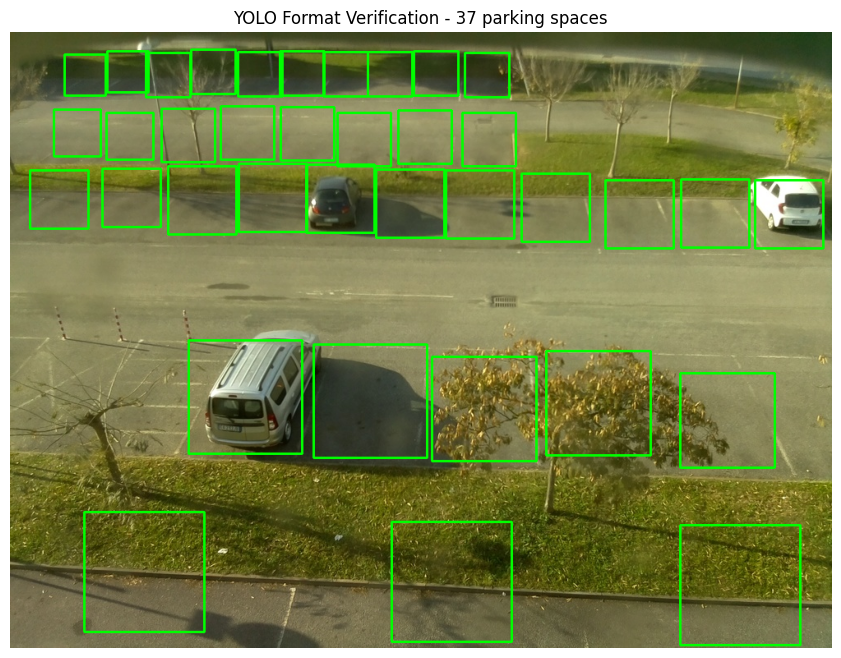


 YOLO dataset info saved to: /content/drive/MyDrive/SmartParkingProject/yolo_dataset_info.json
✅ TASK 2 COMPLETED: YOLO dataset preparation successful!


In [12]:
# ====================================================================
# TASK 2: YOLO DATASET PREPARATION (OPTIMIZED)
# ====================================================================

import yaml
import shutil
from sklearn.model_selection import train_test_split
import json

print("\n" + "="*60)
print("TASK 2: YOLO DATASET PREPARATION (OPTIMIZED)")
print("="*60)

# Load dataset info from Task 1
dataset_info_path = f"{PROJECT_DIR}/dataset_info.json"
try:
    with open(dataset_info_path, 'r') as f:
        dataset_info = json.load(f)
    optimization_needed = dataset_info.get('optimization_needed', False)
    print(f" Dataset info loaded: {dataset_info['total_patches']:,} total patches")
except:
    print(" Dataset info not found, proceeding with default settings")
    optimization_needed = True

# Configuration
ORIGINAL_W, ORIGINAL_H = 2592, 1944
TARGET_W, TARGET_H = 1000, 750

# OPTIMIZATION: Limit number of images for Colab
MAX_IMAGES_PER_CAMERA = 100 if optimization_needed else None
MAX_TOTAL_IMAGES = 2000 if optimization_needed else None

print(f"🔧 Optimization settings:")
print(f"   • Max images per camera: {MAX_IMAGES_PER_CAMERA}")
print(f"   • Max total images: {MAX_TOTAL_IMAGES}")

# Create YOLO dataset directory
YOLO_DIR = Path('/content/CNRPark_YOLO')
if YOLO_DIR.exists():
    shutil.rmtree(YOLO_DIR)

print(f" Creating YOLO dataset structure at {YOLO_DIR}")

# Create directory structure
for split in ['train', 'val', 'test']:
    (YOLO_DIR / 'images' / split).mkdir(parents=True, exist_ok=True)
    (YOLO_DIR / 'labels' / split).mkdir(parents=True, exist_ok=True)

print("✅ YOLO directory structure created")

# Load CSV annotation files
print(" Loading annotation files...")

full_images_dir = Path('/content/FULL_IMAGE_1000x750')
csv_files = list(Path('/content/').glob('camera*.csv'))
all_annotations = {}

for csv_file in csv_files:
    camera_id = int(csv_file.name.replace('camera', '').replace('.csv', ''))
    df = pd.read_csv(csv_file)
    all_annotations[camera_id] = df
    print(f"   Camera {camera_id}: {len(df)} annotations")

print(f"✅ Loaded annotations for {len(all_annotations)} cameras")

# Get all image paths with optimization
print(" Collecting image paths with optimization...")

all_image_paths = []
images_per_camera = {}

for camera_id in range(1, 10):
    camera_images = list(full_images_dir.glob(f'**/camera{camera_id}/*.jpg'))

    # OPTIMIZATION: Limit images per camera
    if MAX_IMAGES_PER_CAMERA and len(camera_images) > MAX_IMAGES_PER_CAMERA:
        camera_images = random.sample(camera_images, MAX_IMAGES_PER_CAMERA)
        print(f"  📹 Camera {camera_id}: Limited to {len(camera_images)} images (from larger set)")
    else:
        print(f"  📹 Camera {camera_id}: {len(camera_images)} images")

    all_image_paths.extend(camera_images)
    images_per_camera[camera_id] = len(camera_images)

# OPTIMIZATION: Limit total images
if MAX_TOTAL_IMAGES and len(all_image_paths) > MAX_TOTAL_IMAGES:
    all_image_paths = random.sample(all_image_paths, MAX_TOTAL_IMAGES)
    print(f"🔧 Limited to {len(all_image_paths)} total images for Colab compatibility")

print(f" Total images to process: {len(all_image_paths)}")

# Create train/val/test splits
random.shuffle(all_image_paths)

# Split ratios: 70% train, 15% val, 15% test
train_ratio, val_ratio = 0.70, 0.15

total_images = len(all_image_paths)
train_end = int(total_images * train_ratio)
val_end = int(total_images * (train_ratio + val_ratio))

train_images = all_image_paths[:train_end]
val_images = all_image_paths[train_end:val_end]
test_images = all_image_paths[val_end:]

splits = {
    'train': train_images,
    'val': val_images,
    'test': test_images
}

print(f" Dataset splits:")
print(f"   Train: {len(train_images)} images")
print(f"   Val: {len(val_images)} images")
print(f"   Test: {len(test_images)} images")

def convert_to_yolo_format(row):
    """Convert CSV annotation to YOLO format"""
    # Get original coordinates
    x, y, w, h = row['X'], row['Y'], row['W'], row['H']

    # Rescale to target dimensions
    x_scaled = x * (TARGET_W / ORIGINAL_W)
    y_scaled = y * (TARGET_H / ORIGINAL_H)
    w_scaled = w * (TARGET_W / ORIGINAL_W)
    h_scaled = h * (TARGET_H / ORIGINAL_H)

    # Convert to YOLO format (center coordinates, normalized)
    x_center = (x_scaled + w_scaled / 2) / TARGET_W
    y_center = (y_scaled + h_scaled / 2) / TARGET_H
    width_norm = w_scaled / TARGET_W
    height_norm = h_scaled / TARGET_H

    # Class ID is 0 for 'parking_space'
    return f"0 {x_center:.6f} {y_center:.6f} {width_norm:.6f} {height_norm:.6f}"

# Process each split with progress tracking
print("\n Converting annotations and copying images...")

total_processed = 0
total_failed = 0

for split_name, image_list in splits.items():
    print(f"\n Processing {split_name} split ({len(image_list)} images)...")

    processed_count = 0
    failed_count = 0

    for image_path in tqdm(image_list, desc=f"Converting {split_name}"):
        try:
            # Extract camera ID from path
            camera_id = None
            for i in range(1, 10):
                if f'camera{i}' in str(image_path):
                    camera_id = i
                    break

            if camera_id is None or camera_id not in all_annotations:
                failed_count += 1
                continue

            # Get annotations for this camera
            annotations_df = all_annotations[camera_id]

            # Create YOLO label file
            label_filename = image_path.with_suffix('.txt').name
            label_path = YOLO_DIR / 'labels' / split_name / label_filename

            # Convert all annotations for this image to YOLO format
            yolo_lines = []
            for _, row in annotations_df.iterrows():
                yolo_line = convert_to_yolo_format(row)
                yolo_lines.append(yolo_line)

            # Write label file
            with open(label_path, 'w') as f:
                f.write('\n'.join(yolo_lines))

            # Copy image to YOLO directory
            dest_image_path = YOLO_DIR / 'images' / split_name / image_path.name
            shutil.copy2(image_path, dest_image_path)

            processed_count += 1

        except Exception as e:
            failed_count += 1
            continue

    print(f"✅ {split_name}: {processed_count} processed, {failed_count} failed")
    total_processed += processed_count
    total_failed += failed_count

print(f"\n Overall Processing Results:")
print(f"  ✅ Successfully processed: {total_processed} images")
print(f"  ❌ Failed: {total_failed} images")
print(f"   Success rate: {(total_processed/(total_processed+total_failed)*100):.1f}%")

# Create data.yaml file
print("\n Creating data.yaml configuration...")

yaml_content = {
    'train': '../CNRPark_YOLO/images/train',
    'val': '../CNRPark_YOLO/images/val',
    'test': '../CNRPark_YOLO/images/test',
    'nc': 1,
    'names': ['parking_space']
}

yaml_path = YOLO_DIR / 'data.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_content, f, default_flow_style=False)

print(f" data.yaml created at {yaml_path}")

# Verification: Show sample YOLO annotations
print("\n Verifying YOLO format conversion...")

def verify_yolo_annotations():
    """Verify YOLO annotations by visualizing on sample image"""
    train_images = list((YOLO_DIR / 'images' / 'train').glob('*.jpg'))
    if not train_images:
        print("❌ No training images found for verification")
        return

    sample_image_path = random.choice(train_images)
    sample_label_path = YOLO_DIR / 'labels' / 'train' / sample_image_path.with_suffix('.txt').name

    if not sample_label_path.exists():
        print("❌ Corresponding label file not found")
        return

    # Load image
    image = cv2.imread(str(sample_image_path))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image_rgb.shape[:2]

    # Load YOLO annotations
    with open(sample_label_path, 'r') as f:
        lines = f.readlines()

    print(f" Sample: {sample_image_path.name} ({len(lines)} annotations)")

    # Draw bounding boxes
    for line in lines:
        parts = line.strip().split()
        if len(parts) == 5:
            class_id, x_center, y_center, width, height = map(float, parts)

            # Convert normalized coordinates back to pixels
            x_center_px = int(x_center * w)
            y_center_px = int(y_center * h)
            width_px = int(width * w)
            height_px = int(height * h)

            # Calculate corner coordinates
            x1 = int(x_center_px - width_px / 2)
            y1 = int(y_center_px - height_px / 2)
            x2 = int(x_center_px + width_px / 2)
            y2 = int(y_center_px + height_px / 2)

            # Draw rectangle
            cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Display
    plt.figure(figsize=(12, 8))
    plt.imshow(image_rgb)
    plt.title(f'YOLO Format Verification - {len(lines)} parking spaces')
    plt.axis('off')
    plt.show()

verify_yolo_annotations()

# Save YOLO dataset info to Drive for persistence
yolo_dataset_info = {
    'total_images_processed': total_processed,
    'train_count': len(train_images),
    'val_count': len(val_images),
    'test_count': len(test_images),
    'cameras_used': list(all_annotations.keys()),
    'yolo_dir': str(YOLO_DIR),
    'optimization_applied': optimization_needed,
    'max_images_per_camera': MAX_IMAGES_PER_CAMERA,
    'max_total_images': MAX_TOTAL_IMAGES
}

with open(f"{PROJECT_DIR}/yolo_dataset_info.json", 'w') as f:
    json.dump(yolo_dataset_info, f, indent=2)

print(f"\n YOLO dataset info saved to: {PROJECT_DIR}/yolo_dataset_info.json")

# Memory cleanup
import gc
gc.collect()

print("✅ TASK 2 COMPLETED: YOLO dataset preparation successful!")


#Task 3


TASK 3: CNN PATCH DATASET PREPARATION
✓ CNN directory structure created
Main dataset: 4182 free, 8402 occupied
Extended dataset: 65658 free, 79307 occupied
Total collected: 69840 free, 87709 occupied
✓ Optimized to: 12500 free, 12500 occupied
Dataset splits:
  train: 7500 free + 7500 occupied = 15000
  val: 2500 free + 2500 occupied = 5000
  test: 2500 free + 2500 occupied = 5000
Copying patches...


✓ All patches copied
Verification:
  train: 7500 free + 7500 occupied = 15000
  val: 2500 free + 2500 occupied = 5000
  test: 2500 free + 2500 occupied = 5000


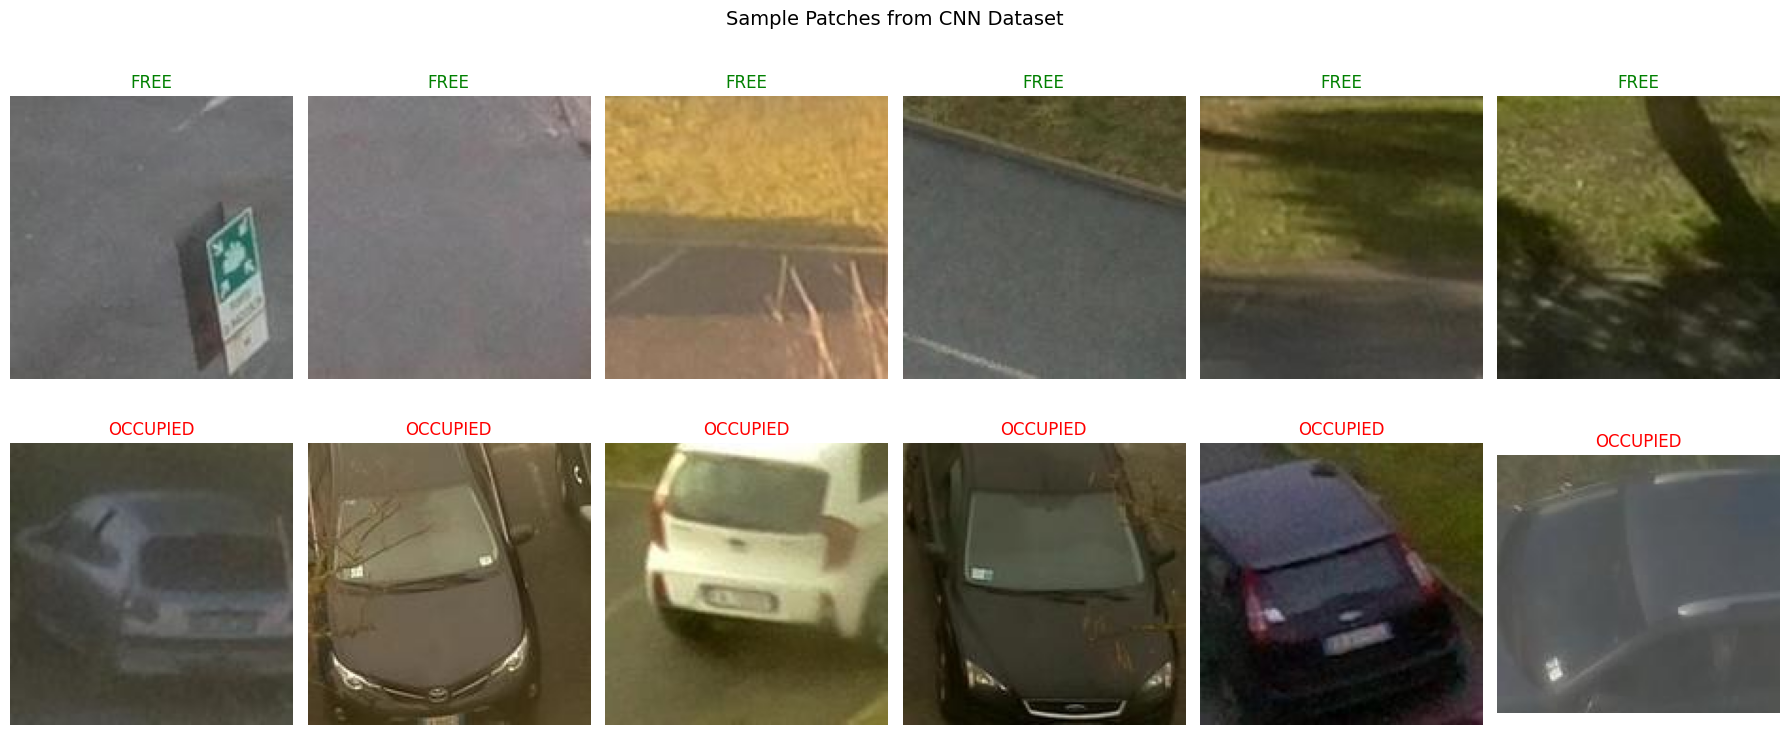

✓ TASK 3 COMPLETED: CNN dataset preparation successful
✓ Optimized dataset size: 25,000 patches


In [13]:
# ====================================================================
# TASK 3: CNN PATCH DATASET PREPARATION (OPTIMIZED) -
# ====================================================================
## Remove this optimization:
# if optimization_needed and (total_free + total_occupied) > recommended_subset:
# Remove this entire block that limits to 25,000 patches
# Or set custom size:
# MAX_PATCHES_PER_CLASS = 50000  # Use up to 50k per class
# if total_free > MAX_PATCHES_PER_CLASS:
#     all_patches['free'] = random.sample(all_patches['free'], MAX_PATCHES_PER_CLASS)
# if total_occupied > MAX_PATCHES_PER_CLASS:
#     all_patches['occupied'] = random.sample(all_patches['occupied'], MAX_PATCHES_PER_CLASS)

from sklearn.model_selection import train_test_split
import glob

print("\nTASK 3: CNN PATCH DATASET PREPARATION")
print("="*50)

# Load optimization settings
try:
    with open(f"{PROJECT_DIR}/dataset_info.json", 'r') as f:
        dataset_info = json.load(f)
    optimization_needed = dataset_info.get('optimization_needed', False)
    recommended_subset = dataset_info.get('recommended_subset', 25000)
except:
    optimization_needed = True
    recommended_subset = 25000

# Create CNN dataset directory
CNN_DIR = Path('/content/CNRPark_CNN')
if CNN_DIR.exists():
    shutil.rmtree(CNN_DIR)

for split in ['train', 'val', 'test']:
    (CNN_DIR / split / 'free').mkdir(parents=True, exist_ok=True)
    (CNN_DIR / split / 'occupied').mkdir(parents=True, exist_ok=True)

print("✓ CNN directory structure created")

# Collect patches from both datasets
all_patches = {'free': [], 'occupied': []}

def collect_main_patches():
    """Collect patches from main dataset (A/B structure)"""
    base_path = Path('/content/patches_main')
    if not base_path.exists():
        return 0, 0

    free_count = occupied_count = 0

    for camera in ['A', 'B']:
        camera_path = base_path / camera
        if camera_path.exists():
            # Free patches
            free_folder = camera_path / 'free'
            if free_folder.exists():
                free_images = list(free_folder.glob('*.jpg'))
                all_patches['free'].extend(free_images)
                free_count += len(free_images)

            # Occupied patches
            busy_folder = camera_path / 'busy'
            if busy_folder.exists():
                occupied_images = list(busy_folder.glob('*.jpg'))
                all_patches['occupied'].extend(occupied_images)
                occupied_count += len(occupied_images)

    return free_count, occupied_count

def collect_extended_patches():
    """Collect patches from extended dataset (weather structure)"""
    base_path = Path('/content/patches_ext')
    if not base_path.exists():
        return 0, 0

    patches_dir = base_path / 'PATCHES'
    labels_dir = base_path / 'LABELS'

    if not patches_dir.exists() or not labels_dir.exists():
        return 0, 0

    # Read label files
    patch_labels = {}
    label_files = list(labels_dir.glob('*.txt'))

    for label_file in label_files:
        try:
            with open(label_file, 'r') as f:
                lines = f.readlines()

            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 2:
                    patch_path = parts[0]
                    label = int(parts[1])
                    patch_labels[patch_path] = label
        except:
            continue

    free_count = occupied_count = 0

    # Collect patches based on labels
    for weather_dir in patches_dir.iterdir():
        if weather_dir.is_dir():
            for date_dir in weather_dir.iterdir():
                if date_dir.is_dir():
                    for camera_dir in date_dir.iterdir():
                        if camera_dir.is_dir():
                            patch_files = list(camera_dir.glob('*.jpg'))

                            for patch_file in patch_files:
                                rel_path = str(patch_file.relative_to(patches_dir)).replace('\\', '/')

                                if rel_path in patch_labels:
                                    label = patch_labels[rel_path]
                                    if label == 0:  # Free
                                        all_patches['free'].append(patch_file)
                                        free_count += 1
                                    else:  # Occupied
                                        all_patches['occupied'].append(patch_file)
                                        occupied_count += 1

    return free_count, occupied_count

# Collect from both datasets
print("Collecting patches...")
main_free, main_occ = collect_main_patches()
ext_free, ext_occ = collect_extended_patches()

total_free = len(all_patches['free'])
total_occupied = len(all_patches['occupied'])

print(f"Main dataset: {main_free} free, {main_occ} occupied")
print(f"Extended dataset: {ext_free} free, {ext_occ} occupied")
print(f"Total collected: {total_free} free, {total_occupied} occupied")

# Apply optimization if needed
if optimization_needed and (total_free + total_occupied) > recommended_subset:
    # Balance and limit dataset size
    max_per_class = recommended_subset // 2

    if total_free > max_per_class:
        all_patches['free'] = random.sample(all_patches['free'], max_per_class)
    if total_occupied > max_per_class:
        all_patches['occupied'] = random.sample(all_patches['occupied'], max_per_class)

    total_free = len(all_patches['free'])
    total_occupied = len(all_patches['occupied'])
    print(f"✓ Optimized to: {total_free} free, {total_occupied} occupied")

# Create train/val/test splits
def split_patches(patch_list, test_size=0.2, val_size=0.2):
    train_val, test = train_test_split(patch_list, test_size=test_size, random_state=42)
    train, val = train_test_split(train_val, test_size=val_size/(1-test_size), random_state=42)
    return train, val, test

free_train, free_val, free_test = split_patches(all_patches['free'])
occ_train, occ_val, occ_test = split_patches(all_patches['occupied'])

splits_info = {
    'train': {'free': len(free_train), 'occupied': len(occ_train)},
    'val': {'free': len(free_val), 'occupied': len(occ_val)},
    'test': {'free': len(free_test), 'occupied': len(occ_test)}
}

print("Dataset splits:")
for split, counts in splits_info.items():
    total = counts['free'] + counts['occupied']
    print(f"  {split}: {counts['free']} free + {counts['occupied']} occupied = {total}")

# Copy patches to CNN dataset directories
def copy_patches(patch_list, dest_dir, class_name, split_name):
    dest_path = CNN_DIR / split_name / class_name

    for i, patch_path in enumerate(tqdm(patch_list, desc=f"{split_name} {class_name}", leave=False)):
        dest_file = dest_path / f"{class_name}_{split_name}_{i:06d}.jpg"
        shutil.copy2(patch_path, dest_file)

print("Copying patches...")
copy_patches(free_train, CNN_DIR, 'free', 'train')
copy_patches(free_val, CNN_DIR, 'free', 'val')
copy_patches(free_test, CNN_DIR, 'free', 'test')

copy_patches(occ_train, CNN_DIR, 'occupied', 'train')
copy_patches(occ_val, CNN_DIR, 'occupied', 'val')
copy_patches(occ_test, CNN_DIR, 'occupied', 'test')

print("✓ All patches copied")

# Verify CNN dataset
print("Verification:")
for split in ['train', 'val', 'test']:
    free_count = len(list((CNN_DIR / split / 'free').glob('*.jpg')))
    occ_count = len(list((CNN_DIR / split / 'occupied').glob('*.jpg')))
    print(f"  {split}: {free_count} free + {occ_count} occupied = {free_count + occ_count}")

# Show sample patches
def show_cnn_samples():
    fig, axes = plt.subplots(2, 6, figsize=(18, 8))
    fig.suptitle('Sample Patches from CNN Dataset', fontsize=14)

    train_free = list((CNN_DIR / 'train' / 'free').glob('*.jpg'))[:6]
    train_occ = list((CNN_DIR / 'train' / 'occupied').glob('*.jpg'))[:6]

    for i, img_path in enumerate(train_free):
        img = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[0, i].imshow(img_rgb)
        axes[0, i].set_title('FREE', color='green')
        axes[0, i].axis('off')

    for i, img_path in enumerate(train_occ):
        img = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[1, i].imshow(img_rgb)
        axes[1, i].set_title('OCCUPIED', color='red')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

show_cnn_samples()

# Save CNN dataset info
cnn_dataset_info = {
    'total_patches': total_free + total_occupied,
    'splits': splits_info,
    'cnn_dir': str(CNN_DIR),
    'optimization_applied': optimization_needed,
    'recommended_subset': recommended_subset
}

with open(f"{PROJECT_DIR}/cnn_dataset_info.json", 'w') as f:
    json.dump(cnn_dataset_info, f, indent=2)

# Memory cleanup
gc.collect()

print("✓ TASK 3 COMPLETED: CNN dataset preparation successful")
if optimization_needed:
    print(f"✓ Optimized dataset size: {total_free + total_occupied:,} patches")

#Task 4

##Test

✓ Requirements installed
TEST configuration (should complete in ~5 minutes):
  img_size: 320
  batch_size: 4
  epochs: 3
  data_yaml: /content/CNRPark_YOLO_TEST/data.yaml
  weights: yolov5n.pt
  project: /content/test_training
  name: mini_test
  device: 0
✓ Backup function works

Starting mini training test...
Command to execute:
python train.py     --img 320     --batch 4     --epochs 3     --data /content/CNRPark_YOLO_TEST/data.yaml     --weights yolov5n.pt     --project /content/test_training     --name mini_test     --device 0     --cache
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics

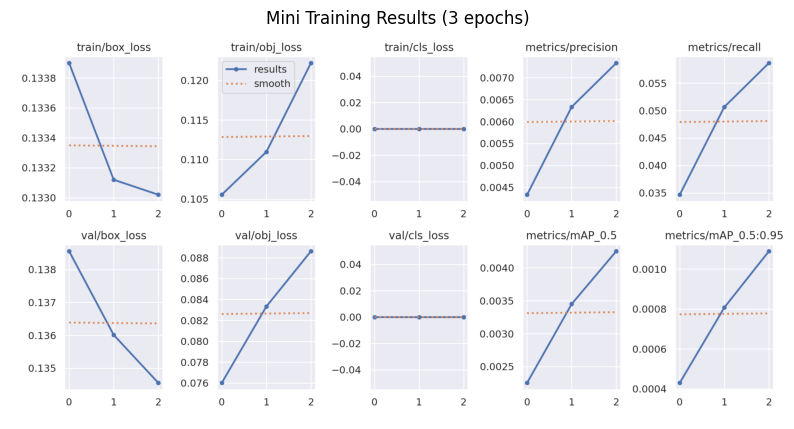

🎉 ALL TESTS PASSED!
✓ Dataset preparation works
✓ YOLO training works
✓ Drive backup works
✓ Model saving works
✓ Validation works

Ready to run full training!
Estimated full training time: 473 seconds (7.9 minutes)

TEST COMPLETED


In [14]:
# ====================================================================
# TASK 4: YOLO TRAINING TEST (MINI DATASET - 5 MINUTES)
# ====================================================================

import torch
from IPython.display import clear_output
import time

print("\nTASK 4: YOLO TRAINING TEST")
print("="*40)

# Check if we have the YOLO dataset
YOLO_DIR = Path('/content/CNRPark_YOLO')
if not YOLO_DIR.exists():
    print("✗ YOLO dataset not found. Please run Task 2 first.")
    exit()

# Quick dataset check
train_images = list((YOLO_DIR / 'images' / 'train').glob('*.jpg'))
val_images = list((YOLO_DIR / 'images' / 'val').glob('*.jpg'))

print(f"Available training images: {len(train_images)}")
print(f"Available validation images: {len(val_images)}")

if len(train_images) < 10:
    print("✗ Not enough training images. Please check Task 2 output.")
    exit()

# Create mini test dataset (only 50 images for quick test)
print("\nCreating mini test dataset...")

MINI_YOLO_DIR = Path('/content/CNRPark_YOLO_TEST')
if MINI_YOLO_DIR.exists():
    shutil.rmtree(MINI_YOLO_DIR)

# Create mini directory structure
for split in ['train', 'val', 'test']:
    (MINI_YOLO_DIR / 'images' / split).mkdir(parents=True, exist_ok=True)
    (MINI_YOLO_DIR / 'labels' / split).mkdir(parents=True, exist_ok=True)

# Copy small subset for testing
def create_mini_dataset():
    # Use only 30 train, 10 val, 10 test images
    mini_counts = {'train': 30, 'val': 10, 'test': 10}

    for split, count in mini_counts.items():
        source_images = list((YOLO_DIR / 'images' / split).glob('*.jpg'))
        source_labels = list((YOLO_DIR / 'labels' / split).glob('*.txt'))

        if len(source_images) >= count:
            # Copy subset of images and labels
            selected_images = source_images[:count]

            for img_path in selected_images:
                # Copy image
                dest_img = MINI_YOLO_DIR / 'images' / split / img_path.name
                shutil.copy2(img_path, dest_img)

                # Copy corresponding label
                label_name = img_path.with_suffix('.txt').name
                source_label = YOLO_DIR / 'labels' / split / label_name

                if source_label.exists():
                    dest_label = MINI_YOLO_DIR / 'labels' / split / label_name
                    shutil.copy2(source_label, dest_label)

            print(f"✓ {split}: {len(selected_images)} images copied")
        else:
            print(f"✗ {split}: Only {len(source_images)} available, need {count}")

create_mini_dataset()

# Create mini data.yaml
mini_yaml_content = {
    'train': '../CNRPark_YOLO_TEST/images/train',
    'val': '../CNRPark_YOLO_TEST/images/val',
    'test': '../CNRPark_YOLO_TEST/images/test',
    'nc': 1,
    'names': ['parking_space']
}

mini_yaml_path = MINI_YOLO_DIR / 'data.yaml'
with open(mini_yaml_path, 'w') as f:
    yaml.dump(mini_yaml_content, f, default_flow_style=False)

print("✓ Mini dataset created")

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Clone YOLOv5 if needed
YOLO_REPO_DIR = Path('/content/yolov5')
if not YOLO_REPO_DIR.exists():
    print("Cloning YOLOv5...")
    !git clone https://github.com/ultralytics/yolov5.git
    print("✓ YOLOv5 cloned")

os.chdir('/content/yolov5')

if not Path('requirements.txt').exists():
    print("✗ YOLOv5 not properly cloned")
    exit()

print("Installing requirements...")
!pip install -q -r requirements.txt
clear_output()
print("✓ Requirements installed")

# TEST TRAINING CONFIGURATION (Very minimal for quick test)
TEST_CONFIG = {
    'img_size': 320,        # Much smaller
    'batch_size': 4,        # Small batch
    'epochs': 3,            # Only 3 epochs
    'data_yaml': str(mini_yaml_path),
    'weights': 'yolov5n.pt',  # Nano model (smallest/fastest)
    'project': '/content/test_training',
    'name': 'mini_test',
    'device': '0' if torch.cuda.is_available() else 'cpu'
}

print("TEST configuration (should complete in ~5 minutes):")
for key, value in TEST_CONFIG.items():
    print(f"  {key}: {value}")

# Test backup function
def test_backup():
    """Test the backup functionality"""
    test_dir = Path('/content/test_source')
    backup_dir = Path('/content/drive/MyDrive/SmartParkingProject/TEST_BACKUP')

    # Create test files
    test_dir.mkdir(exist_ok=True)
    (test_dir / 'weights').mkdir(exist_ok=True)

    # Create dummy files
    with open(test_dir / 'weights' / 'test.pt', 'w') as f:
        f.write('test model')
    with open(test_dir / 'test_results.txt', 'w') as f:
        f.write('test results')

    # Test backup
    try:
        backup_dir.mkdir(parents=True, exist_ok=True)
        shutil.copytree(test_dir, backup_dir / 'test_run', dirs_exist_ok=True)

        if (backup_dir / 'test_run' / 'weights' / 'test.pt').exists():
            print("✓ Backup function works")
            return True
        else:
            print("✗ Backup function failed")
            return False
    except Exception as e:
        print(f"✗ Backup error: {e}")
        return False

# Test backup functionality
backup_works = test_backup()

if not backup_works:
    print("✗ Backup test failed. Check Drive permissions.")
    exit()

# Execute mini training
print("\nStarting mini training test...")

training_command = f"""python train.py \
    --img {TEST_CONFIG['img_size']} \
    --batch {TEST_CONFIG['batch_size']} \
    --epochs {TEST_CONFIG['epochs']} \
    --data {TEST_CONFIG['data_yaml']} \
    --weights {TEST_CONFIG['weights']} \
    --project {TEST_CONFIG['project']} \
    --name {TEST_CONFIG['name']} \
    --device {TEST_CONFIG['device']} \
    --cache"""

print("Command to execute:")
print(training_command)

start_time = time.time()
!{training_command}
end_time = time.time()

training_time = end_time - start_time
print(f"Training completed in {training_time:.1f} seconds")

# Check results
test_run_dir = Path(TEST_CONFIG['project']) / TEST_CONFIG['name']
best_model = test_run_dir / 'weights' / 'best.pt'

if best_model.exists():
    print("✓ Mini training successful!")
    print(f"✓ Model saved: {best_model}")

    # Test backup of results
    drive_backup = Path('/content/drive/MyDrive/SmartParkingProject/TEST_TRAINING_BACKUP')
    try:
        shutil.copytree(test_run_dir, drive_backup, dirs_exist_ok=True)
        print("✓ Backup to Drive successful!")

        # Show what was backed up
        backed_up_files = list(drive_backup.rglob('*'))
        print(f"✓ {len(backed_up_files)} files backed up to Drive")

    except Exception as e:
        print(f"✗ Backup failed: {e}")

    # Quick validation test
    print("\nTesting quick validation...")
    val_command = f"""python val.py \
        --weights {best_model} \
        --data {TEST_CONFIG['data_yaml']} \
        --img {TEST_CONFIG['img_size']} \
        --task val"""

    !{val_command}
    print("✓ Validation test completed")

    # Show results if available
    results_img = test_run_dir / 'results.png'
    if results_img.exists():
        img = cv2.imread(str(results_img))
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(10, 6))
            plt.imshow(img_rgb)
            plt.title('Mini Training Results (3 epochs)')
            plt.axis('off')
            plt.show()

    print("="*50)
    print("🎉 ALL TESTS PASSED!")
    print("="*50)
    print("✓ Dataset preparation works")
    print("✓ YOLO training works")
    print("✓ Drive backup works")
    print("✓ Model saving works")
    print("✓ Validation works")
    print("")
    print("Ready to run full training!")
    print(f"Estimated full training time: {training_time * 10:.0f} seconds ({training_time * 10 / 60:.1f} minutes)")

else:
    print("✗ Mini training failed!")
    print("Check the error messages above.")

    # List what's in the training directory
    if test_run_dir.exists():
        files = list(test_run_dir.rglob('*'))
        print(f"Files created: {[f.name for f in files if f.is_file()]}")

print("\n" + "="*50)
print("TEST COMPLETED")
print("="*50)

##Final

✓ Requirements installed
Training locally: /content/yolo_training
Backup to Drive: /content/drive/MyDrive/SmartParkingProject/YOLO_Training
Training configuration:
  img_size: 640
  batch_size: 16
  epochs: 30
  data_yaml: /content/CNRPark_YOLO/data.yaml
  weights: yolov5s.pt
  project: /content/yolo_training
  name: parking_detection_v1
  device: 0
Starting training...
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-07-23 22:21:40.916105: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753309300.937214   16945 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753309300.943659   16945 cuda_blas.cc:1418] Unable to register cuBLA

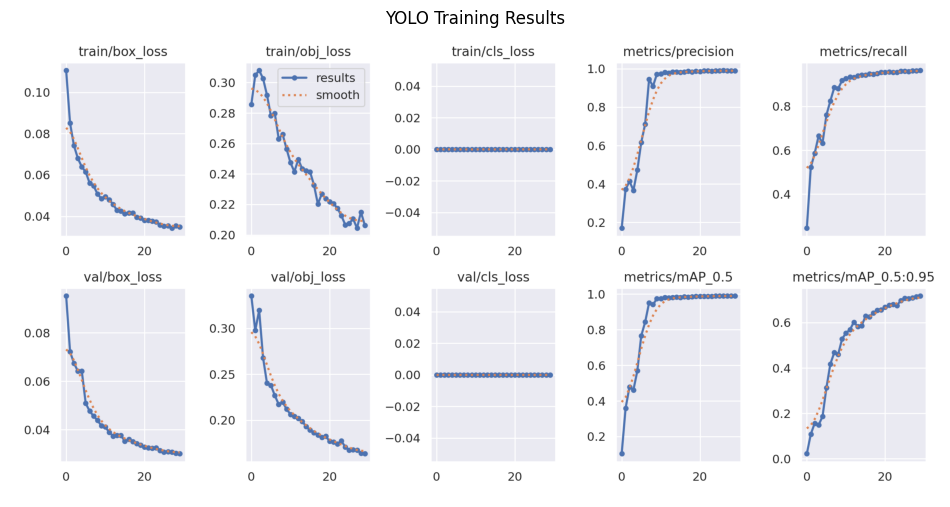

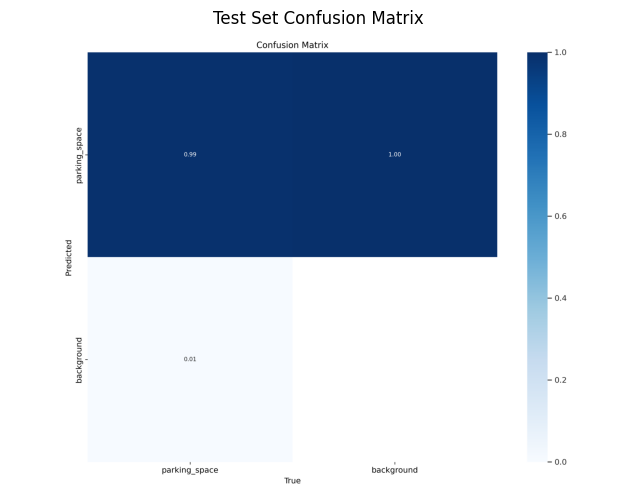

✓ Model saved locally: /content/yolo_training/parking_detection_v1/weights/best.pt
✓ Model backed up to Drive: /content/drive/MyDrive/SmartParkingProject/YOLO_Training/parking_detection_v1/weights/best.pt
✓ TASK 4 COMPLETED: YOLO training finished with Drive backup


In [15]:
# ====================================================================
# TASK 4: YOLO TRAINING (OPTIMIZED WITH DRIVE BACKUP)
# ====================================================================
# YOLO_CONFIG change this if dont want to optimize
import torch
from IPython.display import clear_output
import time

print("\nTASK 4: YOLO TRAINING")
print("="*30)

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Clone YOLOv5
YOLO_REPO_DIR = Path('/content/yolov5')
if not YOLO_REPO_DIR.exists():
    print("Cloning YOLOv5...")
    !git clone https://github.com/ultralytics/yolov5.git
    print("✓ YOLOv5 cloned")
else:
    print("✓ YOLOv5 already exists")

os.chdir('/content/yolov5')

print("Installing requirements...")
!pip install -q -r requirements.txt
clear_output()
print("✓ Requirements installed")

# Load optimization settings
try:
    with open(f"{PROJECT_DIR}/yolo_dataset_info.json", 'r') as f:
        yolo_info = json.load(f)
    optimization_applied = yolo_info.get('optimization_applied', True)
    train_count = yolo_info.get('train_count', 1000)
except:
    optimization_applied = True
    train_count = 1000

# Training directories
YOLO_TRAINING_DIR_LOCAL = '/content/yolo_training'  # Fast local training
YOLO_TRAINING_DIR_DRIVE = f"{PROJECT_DIR}/YOLO_Training"  # Drive backup
os.makedirs(YOLO_TRAINING_DIR_LOCAL, exist_ok=True)
os.makedirs(YOLO_TRAINING_DIR_DRIVE, exist_ok=True)

print(f"Training locally: {YOLO_TRAINING_DIR_LOCAL}")
print(f"Backup to Drive: {YOLO_TRAINING_DIR_DRIVE}")

# Optimization :
# Training configuration (optimized for training)
YOLO_CONFIG = {
    'img_size': 640,  # Reduced from 1000
    'batch_size': 16 if train_count < 1500 else 8,
    'epochs': 30 if optimization_applied else 50,  # Reduced epochs
    'data_yaml': str(YOLO_DIR / 'data.yaml'),
    'weights': 'yolov5s.pt',
    'project': YOLO_TRAINING_DIR_LOCAL,
    'name': 'parking_detection_v1',
    'device': '0' if torch.cuda.is_available() else 'cpu'
}

print("Training configuration:")
for key, value in YOLO_CONFIG.items():
    print(f"  {key}: {value}")

# Function to backup checkpoints to Drive
def backup_to_drive(local_run_dir, drive_backup_dir):
    """Backup training checkpoints and results to Drive"""
    try:
        if Path(local_run_dir).exists():
            # Create backup directory
            os.makedirs(drive_backup_dir, exist_ok=True)

            # Copy important files
            important_files = [
                'weights/best.pt',
                'weights/last.pt',
                'results.png',
                'confusion_matrix.png',
                'opt.yaml',
                'hyp.yaml'
            ]

            for file_path in important_files:
                src = Path(local_run_dir) / file_path
                if src.exists():
                    dst = Path(drive_backup_dir) / file_path
                    dst.parent.mkdir(parents=True, exist_ok=True)
                    shutil.copy2(src, dst)

            print(f"✓ Backed up to Drive: {drive_backup_dir}")
            return True
    except Exception as e:
        print(f"✗ Backup failed: {e}")
        return False

# Custom training with periodic backups
def train_with_backup():
    """Train YOLO with periodic Drive backups"""

    # Build training command
    training_command = f"""python train.py \
        --img {YOLO_CONFIG['img_size']} \
        --batch {YOLO_CONFIG['batch_size']} \
        --epochs {YOLO_CONFIG['epochs']} \
        --data {YOLO_CONFIG['data_yaml']} \
        --weights {YOLO_CONFIG['weights']} \
        --project {YOLO_CONFIG['project']} \
        --name {YOLO_CONFIG['name']} \
        --device {YOLO_CONFIG['device']} \
        --save-period 10 \
        --cache"""

    print("Starting training...")

    # Start training in background and monitor for checkpoints
    import subprocess
    import threading

    # Local run directory
    local_run_dir = Path(YOLO_TRAINING_DIR_LOCAL) / YOLO_CONFIG['name']
    drive_backup_dir = Path(YOLO_TRAINING_DIR_DRIVE) / YOLO_CONFIG['name']

    # Function to monitor and backup
    def monitor_and_backup():
        last_backup_time = 0
        backup_interval = 600  # Backup every 10 minutes

        while True:
            time.sleep(30)  # Check every 30 seconds

            current_time = time.time()
            weights_dir = local_run_dir / 'weights'

            # Check if weights directory exists and has been updated
            if weights_dir.exists():
                # Backup if interval passed or best.pt was updated recently
                if (current_time - last_backup_time) > backup_interval:
                    if backup_to_drive(str(local_run_dir), str(drive_backup_dir)):
                        last_backup_time = current_time

                # Check if training completed
                if (weights_dir / 'best.pt').exists() and (weights_dir / 'last.pt').exists():
                    # Final backup
                    backup_to_drive(str(local_run_dir), str(drive_backup_dir))
                    break

    # Start monitoring thread
    monitor_thread = threading.Thread(target=monitor_and_backup, daemon=True)
    monitor_thread.start()

    # Execute training
    !{training_command}

    # Wait for monitoring to complete
    time.sleep(5)

    return local_run_dir, drive_backup_dir

# Execute training with backup
local_run_dir, drive_backup_dir = train_with_backup()

# Final verification and backup
BEST_MODEL_PATH_LOCAL = local_run_dir / 'weights' / 'best.pt'
BEST_MODEL_PATH_DRIVE = drive_backup_dir / 'weights' / 'best.pt'

if BEST_MODEL_PATH_LOCAL.exists():
    print("✓ Training completed")

    # Ensure final backup
    backup_to_drive(str(local_run_dir), str(drive_backup_dir))

    # Run validation
    print("Running validation...")
    validation_command = f"""python val.py \
        --weights {BEST_MODEL_PATH_LOCAL} \
        --data {YOLO_CONFIG['data_yaml']} \
        --img {YOLO_CONFIG['img_size']} \
        --task test \
        --project {YOLO_TRAINING_DIR_LOCAL} \
        --name test_evaluation \
        --save-txt \
        --save-conf"""

    !{validation_command}

    # Backup validation results
    val_results_local = Path(YOLO_TRAINING_DIR_LOCAL) / 'test_evaluation'
    val_results_drive = Path(YOLO_TRAINING_DIR_DRIVE) / 'test_evaluation'
    if val_results_local.exists():
        shutil.copytree(val_results_local, val_results_drive, dirs_exist_ok=True)
        print("✓ Validation results backed up to Drive")

    # Display results
    results_img = local_run_dir / 'results.png'
    if results_img.exists():
        img = cv2.imread(str(results_img))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(12, 8))
        plt.imshow(img_rgb)
        plt.title('YOLO Training Results')
        plt.axis('off')
        plt.show()

    # Show confusion matrix
    confusion_matrix_img = val_results_local / 'confusion_matrix.png'
    if confusion_matrix_img.exists():
        img = cv2.imread(str(confusion_matrix_img))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(8, 6))
        plt.imshow(img_rgb)
        plt.title('Test Set Confusion Matrix')
        plt.axis('off')
        plt.show()

    # Save model info to both locations
    yolo_model_info = {
        'best_model_path_local': str(BEST_MODEL_PATH_LOCAL),
        'best_model_path_drive': str(BEST_MODEL_PATH_DRIVE),
        'training_config': YOLO_CONFIG,
        'optimization_applied': optimization_applied,
        'train_images': train_count,
        'local_training_dir': str(local_run_dir),
        'drive_backup_dir': str(drive_backup_dir)
    }

    # Save to both locations
    with open(f"{local_run_dir}/model_info.json", 'w') as f:
        json.dump(yolo_model_info, f, indent=2)

    with open(f"{drive_backup_dir}/model_info.json", 'w') as f:
        json.dump(yolo_model_info, f, indent=2)

    print(f"✓ Model saved locally: {BEST_MODEL_PATH_LOCAL}")
    print(f"✓ Model backed up to Drive: {BEST_MODEL_PATH_DRIVE}")

else:
    print("✗ Training failed")

print("✓ TASK 4 COMPLETED: YOLO training finished with Drive backup")

#Task 5



TASK 5: CNN TRAINING
Device: cuda
Train: 15000, Val: 5000, Test: 5000
Classes: ['free', 'occupied']
Model parameters: 11,072,642
Starting training...
Epoch 1/30
  Train Loss: 0.2858, Train Acc: 90.97%
  Val Loss: 0.1363, Val Acc: 95.34%
  New best model saved! Val Acc: 95.34%
Epoch 2/30
  Train Loss: 0.1884, Train Acc: 93.77%
  Val Loss: 0.1373, Val Acc: 95.84%
  New best model saved! Val Acc: 95.84%
Epoch 3/30
  Train Loss: 0.1593, Train Acc: 94.68%
  Val Loss: 0.1140, Val Acc: 96.38%
  New best model saved! Val Acc: 96.38%
Epoch 4/30
  Train Loss: 0.1492, Train Acc: 94.93%
  Val Loss: 0.1133, Val Acc: 95.78%
Epoch 5/30
  Train Loss: 0.1502, Train Acc: 95.03%
  Val Loss: 0.0945, Val Acc: 96.62%
  New best model saved! Val Acc: 96.62%
Epoch 6/30
  Train Loss: 0.1411, Train Acc: 95.51%
  Val Loss: 0.0918, Val Acc: 96.76%
  New best model saved! Val Acc: 96.76%
Epoch 7/30
  Train Loss: 0.1419, Train Acc: 95.42%
  Val Loss: 0.0909, Val Acc: 96.52%
Epoch 8/30
  Train Loss: 0.1352, Train A

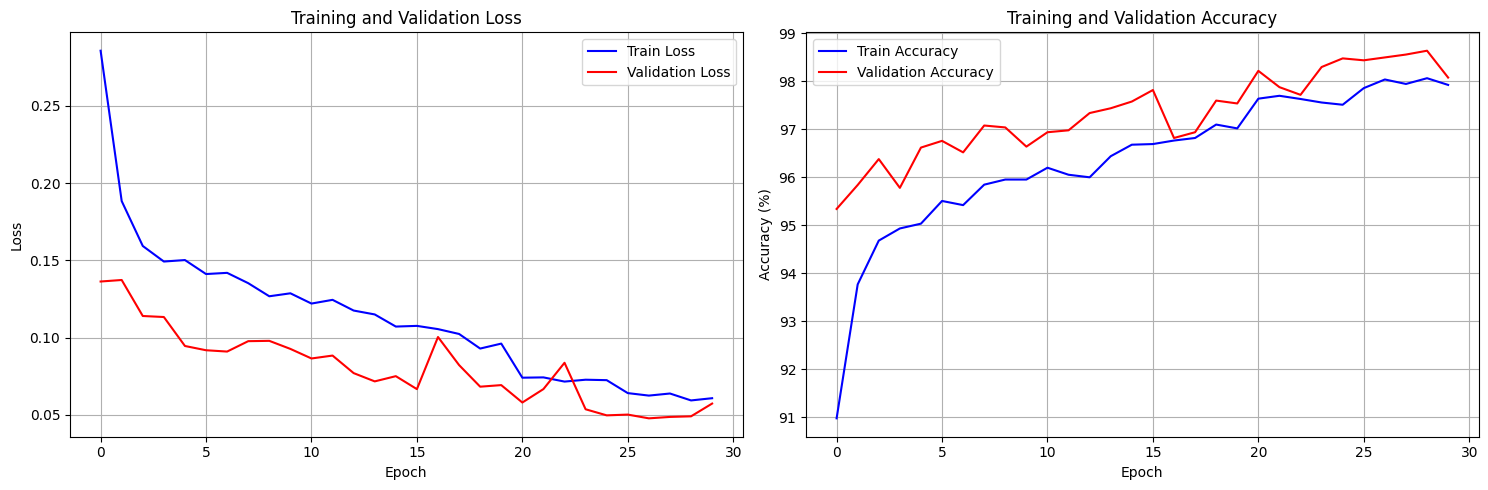

Evaluating on test set...
Test Accuracy: 98.56%

Classification Report:
              precision    recall  f1-score   support

        free       0.98      0.99      0.99      2500
    occupied       0.99      0.98      0.99      2500

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



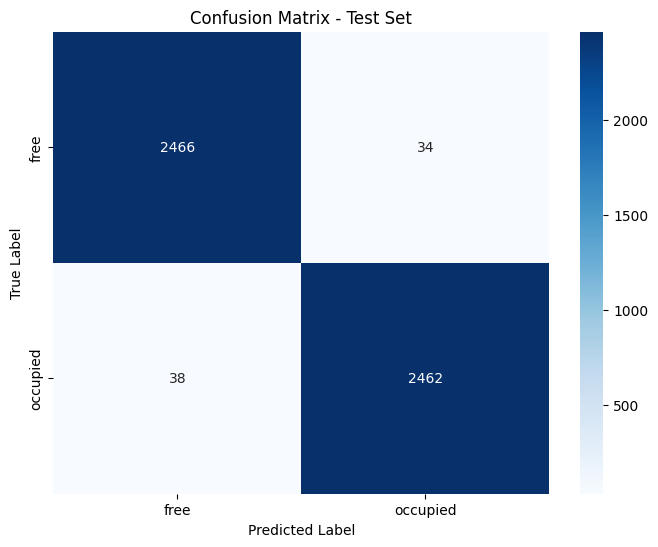

TASK 5 COMPLETED: CNN training finished
Local model: /content/cnn_training/best_model.pth
Drive backup: /content/drive/MyDrive/SmartParkingProject/CNN_Training/best_model.pth


In [16]:
# ====================================================================
# TASK 5: CNN TRAINING (OCCUPANCY CLASSIFICATION)
# ====================================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("\nTASK 5: CNN TRAINING")
print("="*30)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Training directories
CNN_TRAINING_DIR_LOCAL = '/content/cnn_training'
CNN_TRAINING_DIR_DRIVE = f"{PROJECT_DIR}/CNN_Training"
os.makedirs(CNN_TRAINING_DIR_LOCAL, exist_ok=True)
os.makedirs(CNN_TRAINING_DIR_DRIVE, exist_ok=True)

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = ImageFolder(str(CNN_DIR / 'train'), transform=train_transform)
val_dataset = ImageFolder(str(CNN_DIR / 'val'), transform=val_transform)
test_dataset = ImageFolder(str(CNN_DIR / 'test'), transform=val_transform)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")

# Create data loaders
BATCH_SIZE = 32
NUM_WORKERS = 2

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# CNN Model
class ParkingSpotCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(ParkingSpotCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)

        self.pool = nn.MaxPool2d(2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(256 * 9 * 9, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

# Initialize model
model = ParkingSpotCNN(num_classes=2).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {total_params:,}")

# Training configuration
LEARNING_RATE = 0.001
NUM_EPOCHS = 30
PATIENCE = 7

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# Backup function
def backup_model(epoch, is_best=False):
    try:
        local_path = f"{CNN_TRAINING_DIR_LOCAL}/model_epoch_{epoch}.pth"
        drive_path = f"{CNN_TRAINING_DIR_DRIVE}/model_epoch_{epoch}.pth"

        torch.save(model.state_dict(), local_path)
        torch.save(model.state_dict(), drive_path)

        if is_best:
            torch.save(model.state_dict(), f"{CNN_TRAINING_DIR_LOCAL}/best_model.pth")
            torch.save(model.state_dict(), f"{CNN_TRAINING_DIR_DRIVE}/best_model.pth")

        return True
    except:
        return False

# Training functions
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

# Training loop
print("Starting training...")

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_acc = 0.0
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    scheduler.step(val_loss)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        backup_model(epoch, is_best=True)
        print(f"  New best model saved! Val Acc: {val_acc:.2f}%")
        patience_counter = 0
    else:
        patience_counter += 1

    # Backup every 10 epochs
    if (epoch + 1) % 10 == 0:
        backup_model(epoch)

    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"  Early stopping after {epoch+1} epochs")
        break

print(f"Training completed! Best validation accuracy: {best_val_acc:.2f}%")

# Load best model
model.load_state_dict(torch.load(f"{CNN_TRAINING_DIR_LOCAL}/best_model.pth"))

# Plot training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Test evaluation
print("Evaluating on test set...")

def evaluate_model(model, test_loader, device, class_names):
    model.eval()

    all_predictions = []
    all_targets = []
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

            total += target.size(0)
            correct += (predicted == target).sum().item()

    test_accuracy = 100. * correct / total

    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print("\nClassification Report:")
    print(classification_report(all_targets, all_predictions, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Test Set')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return test_accuracy, all_predictions, all_targets

# Run evaluation
test_accuracy, predictions, targets = evaluate_model(
    model, test_loader, device, train_dataset.classes
)

# Save model info
cnn_model_info = {
    'test_accuracy': test_accuracy,
    'best_val_accuracy': best_val_acc,
    'num_epochs_trained': len(train_losses),
    'model_path_local': f"{CNN_TRAINING_DIR_LOCAL}/best_model.pth",
    'model_path_drive': f"{CNN_TRAINING_DIR_DRIVE}/best_model.pth",
    'classes': train_dataset.classes,
    'class_to_idx': train_dataset.class_to_idx,
    'total_parameters': total_params
}

with open(f"{CNN_TRAINING_DIR_LOCAL}/model_info.json", 'w') as f:
    json.dump(cnn_model_info, f, indent=2)

with open(f"{CNN_TRAINING_DIR_DRIVE}/model_info.json", 'w') as f:
    json.dump(cnn_model_info, f, indent=2)

# Memory cleanup
torch.cuda.empty_cache()
gc.collect()

print("TASK 5 COMPLETED: CNN training finished")
print(f"Local model: {CNN_TRAINING_DIR_LOCAL}/best_model.pth")
print(f"Drive backup: {CNN_TRAINING_DIR_DRIVE}/best_model.pth")

#Task 6



TASK 6: PIPELINE INTEGRATION
YOLO model: /content/drive/MyDrive/SmartParkingProject/YOLO_Training/parking_detection_v1/weights/best.pt
CNN model: /content/drive/MyDrive/SmartParkingProject/CNN_Training/best_model.pth
CNN classes: ['free', 'occupied']
Loading YOLO model...


Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2025-7-23 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


YOLO model loaded
Loading CNN model...
CNN model loaded
Integrated detector initialized
Testing integrated system...
Processing: /content/FULL_IMAGE_1000x750/OVERCAST/2015-11-16/camera3/2015-11-16_1245.jpg


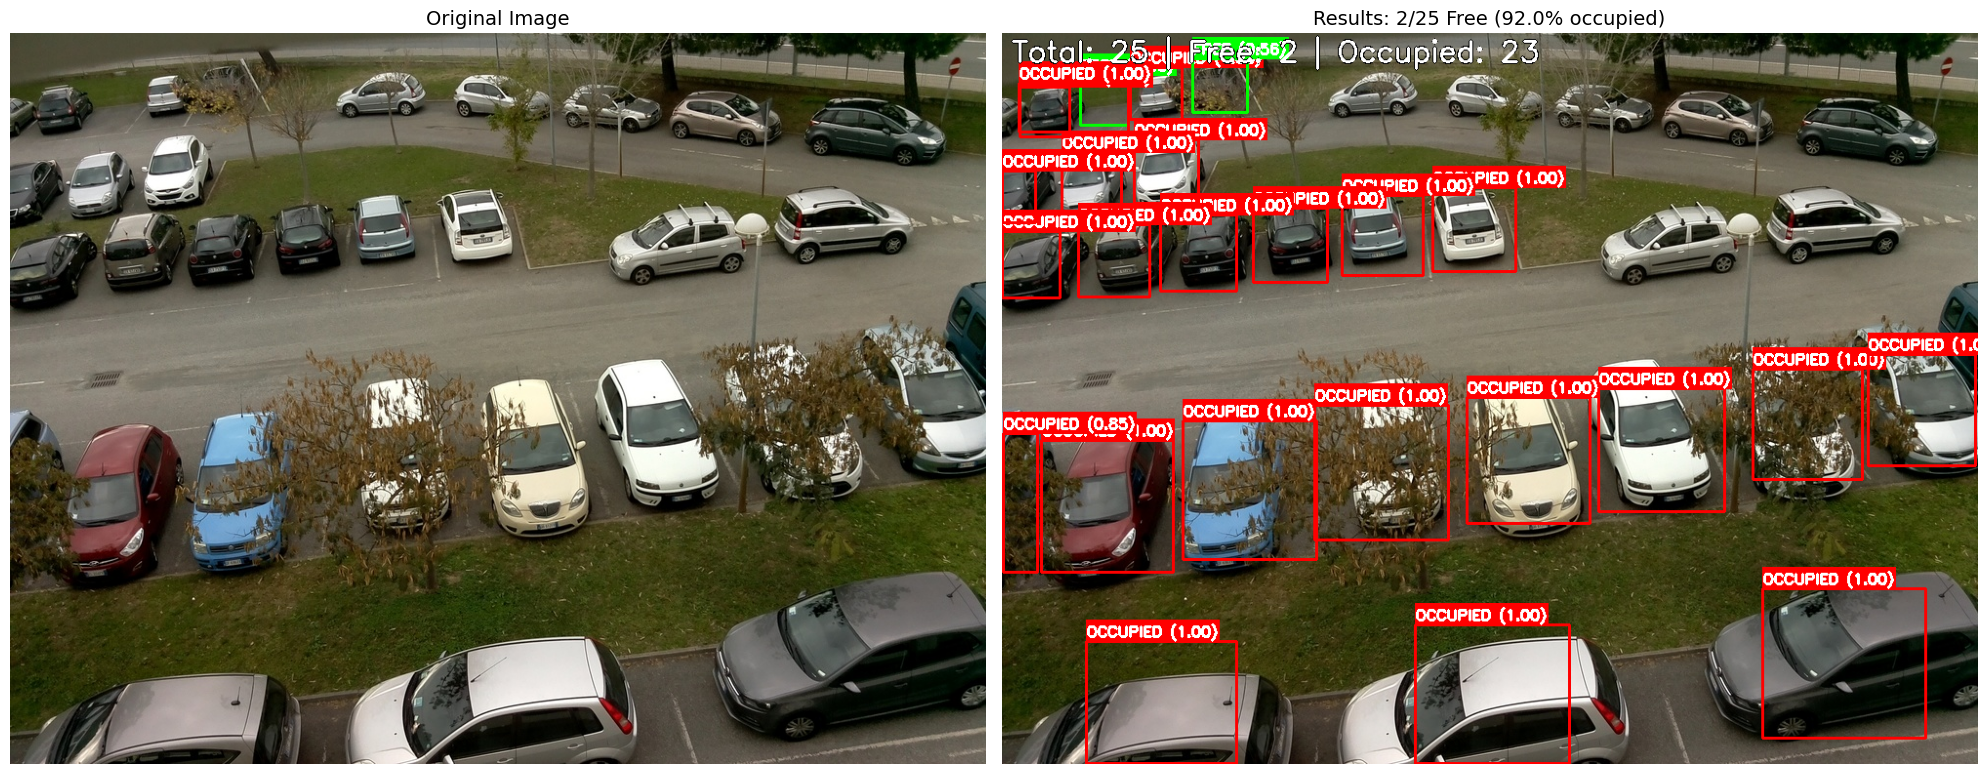


Results Summary:
Total parking spaces detected: 25
Free spaces: 2 (GREEN boxes)
Occupied spaces: 23 (RED boxes)
Occupancy rate: 92.0%

Individual Space Details:
Space 1: OCCUPIED (RED) - YOLO conf: 0.912, CNN conf: 0.999
Space 2: OCCUPIED (RED) - YOLO conf: 0.910, CNN conf: 1.000
Space 3: OCCUPIED (RED) - YOLO conf: 0.909, CNN conf: 1.000
Space 4: OCCUPIED (RED) - YOLO conf: 0.901, CNN conf: 1.000
Space 5: OCCUPIED (RED) - YOLO conf: 0.901, CNN conf: 1.000
Space 6: OCCUPIED (RED) - YOLO conf: 0.900, CNN conf: 1.000
Space 7: OCCUPIED (RED) - YOLO conf: 0.899, CNN conf: 1.000
Space 8: OCCUPIED (RED) - YOLO conf: 0.896, CNN conf: 1.000
Space 9: OCCUPIED (RED) - YOLO conf: 0.880, CNN conf: 1.000
Space 10: OCCUPIED (RED) - YOLO conf: 0.880, CNN conf: 1.000
Space 11: FREE (GREEN) - YOLO conf: 0.870, CNN conf: 1.000
Space 12: OCCUPIED (RED) - YOLO conf: 0.865, CNN conf: 1.000
Space 13: OCCUPIED (RED) - YOLO conf: 0.863, CNN conf: 1.000
Space 14: OCCUPIED (RED) - YOLO conf: 0.859, CNN conf: 1

In [19]:
# ====================================================================
# TASK 6: PIPELINE INTEGRATION (YOLO + CNN)
# ====================================================================

from PIL import Image
import torch
import cv2
import numpy as np
import torch.nn.functional as F

print("\nTASK 6: PIPELINE INTEGRATION")
print("="*40)

# Load model paths
try:
    with open(f"{PROJECT_DIR}/YOLO_Training/parking_detection_v1/model_info.json", 'r') as f:
        yolo_info = json.load(f)
    yolo_model_path = yolo_info['best_model_path_drive']
    print(f"YOLO model: {yolo_model_path}")
except:
    yolo_model_path = f"{PROJECT_DIR}/YOLO_Training/parking_detection_v1/weights/best.pt"
    print(f"YOLO model (fallback): {yolo_model_path}")

try:
    with open(f"{PROJECT_DIR}/CNN_Training/model_info.json", 'r') as f:
        cnn_info = json.load(f)
    cnn_model_path = cnn_info['model_path_drive']
    cnn_classes = cnn_info['classes']
    print(f"CNN model: {cnn_model_path}")
    print(f"CNN classes: {cnn_classes}")
except:
    cnn_model_path = f"{PROJECT_DIR}/CNN_Training/best_model.pth"
    cnn_classes = ['free', 'occupied']
    print(f"CNN model (fallback): {cnn_model_path}")

# Load YOLO model
print("Loading YOLO model...")
try:
    os.chdir('/content/yolov5')
    yolo_model = torch.hub.load('ultralytics/yolov5', 'custom', path=yolo_model_path, force_reload=True)
    yolo_model.conf = 0.25
    yolo_model.iou = 0.45
    print("YOLO model loaded")
except Exception as e:
    print(f"YOLO loading failed: {e}")
    yolo_model = None

# Load CNN model
print("Loading CNN model...")
try:
    # Recreate CNN architecture
    class ParkingSpotCNN(nn.Module):
        def __init__(self, num_classes=2):
            super(ParkingSpotCNN, self).__init__()

            self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
            self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
            self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
            self.conv4 = nn.Conv2d(128, 256, 3, padding=1)

            self.pool = nn.MaxPool2d(2)
            self.bn1 = nn.BatchNorm2d(32)
            self.bn2 = nn.BatchNorm2d(64)
            self.bn3 = nn.BatchNorm2d(128)
            self.bn4 = nn.BatchNorm2d(256)

            self.dropout = nn.Dropout(0.5)

            self.fc1 = nn.Linear(256 * 9 * 9, 512)
            self.fc2 = nn.Linear(512, 128)
            self.fc3 = nn.Linear(128, num_classes)

        def forward(self, x):
            x = self.pool(F.relu(self.bn1(self.conv1(x))))
            x = self.pool(F.relu(self.bn2(self.conv2(x))))
            x = self.pool(F.relu(self.bn3(self.conv3(x))))
            x = self.pool(F.relu(self.bn4(self.conv4(x))))

            x = x.view(x.size(0), -1)

            x = F.relu(self.fc1(x))
            x = self.dropout(x)
            x = F.relu(self.fc2(x))
            x = self.dropout(x)
            x = self.fc3(x)

            return x

    cnn_model = ParkingSpotCNN(num_classes=2).to(device)
    cnn_model.load_state_dict(torch.load(cnn_model_path, map_location=device))
    cnn_model.eval()
    print("CNN model loaded")
except Exception as e:
    print(f"CNN loading failed: {e}")
    cnn_model = None

# CNN preprocessing
cnn_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Integrated Pipeline
class SmartParkingDetector:
    def __init__(self, yolo_model, cnn_model, cnn_transform, device, class_names):
        self.yolo_model = yolo_model
        self.cnn_model = cnn_model
        self.cnn_transform = cnn_transform
        self.device = device
        self.class_names = class_names

    def detect_parking_spaces(self, image):
        if self.yolo_model is None:
            return []

        results = self.yolo_model(image)
        detections = []

        for *box, conf, cls in results.xyxy[0].cpu().numpy():
            x1, y1, x2, y2 = map(int, box)
            detections.append({
                'bbox': [x1, y1, x2, y2],
                'confidence': float(conf),
                'class': int(cls)
            })

        return detections

    def classify_occupancy(self, image, bbox):
        if self.cnn_model is None:
            return 'unknown', 0.0

        x1, y1, x2, y2 = bbox
        patch = image[y1:y2, x1:x2]

        if patch.size == 0:
            return 'unknown', 0.0

        # Preprocess patch
        patch_pil = Image.fromarray(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))
        patch_tensor = self.cnn_transform(patch_pil).unsqueeze(0).to(self.device)

        # Predict
        with torch.no_grad():
            output = self.cnn_model(patch_tensor)
            probabilities = F.softmax(output, dim=1)
            confidence, predicted = torch.max(probabilities, 1)

        class_name = self.class_names[predicted.item()]
        confidence_score = confidence.item()

        return class_name, confidence_score

    def process_image(self, image_path):
        if isinstance(image_path, str):
            image = cv2.imread(image_path)
        else:
            image = image_path

        if image is None:
            return None, None

        # Step 1: Detect parking spaces
        detections = self.detect_parking_spaces(image)

        # Step 2: Classify each detection
        results = []
        for detection in detections:
            occupancy, confidence = self.classify_occupancy(image, detection['bbox'])

            result = {
                'bbox': detection['bbox'],
                'yolo_confidence': detection['confidence'],
                'occupancy': occupancy,
                'occupancy_confidence': confidence,
                'combined_confidence': detection['confidence'] * confidence
            }
            results.append(result)

        return results, image

    def visualize_results(self, image, results):
        vis_image = image.copy()

        free_count = 0
        occupied_count = 0

        for result in results:
            x1, y1, x2, y2 = result['bbox']
            occupancy = result['occupancy']
            occ_conf = result['occupancy_confidence']

            # Choose color
            if occupancy == 'free':
                color = (0, 255, 0)  # Green
                free_count += 1
            elif occupancy == 'occupied':
                color = (0, 0, 255)  # Red
                occupied_count += 1
            else:
                color = (0, 255, 255)  # Yellow

            # Draw bounding box
            cv2.rectangle(vis_image, (x1, y1), (x2, y2), color, 2)

            # Add label
            label = f"{occupancy.upper()} ({occ_conf:.2f})"
            label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]

            cv2.rectangle(vis_image, (x1, y1 - label_size[1] - 10),
                         (x1 + label_size[0], y1), color, -1)

            cv2.putText(vis_image, label, (x1, y1 - 5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        # Add summary
        total_spots = len(results)
        summary = f"Total: {total_spots} | Free: {free_count} | Occupied: {occupied_count}"

        cv2.putText(vis_image, summary, (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 3)
        cv2.putText(vis_image, summary, (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        return vis_image, {
            'total': total_spots,
            'free': free_count,
            'occupied': occupied_count,
            'occupancy_rate': (occupied_count / total_spots * 100) if total_spots > 0 else 0
        }

# Initialize detector
if yolo_model is not None and cnn_model is not None:
    detector = SmartParkingDetector(
        yolo_model=yolo_model,
        cnn_model=cnn_model,
        cnn_transform=cnn_transform,
        device=device,
        class_names=cnn_classes
    )
    print("Integrated detector initialized")
else:
    print("Cannot initialize detector - models not loaded")
    detector = None

# Test integration with single image
print("Testing integrated system...")

def test_single_image(image_path):
    """Test detector on a single specific image"""
    if detector is None:
        print("Detector not available")
        return

    if not Path(image_path).exists():
        print(f"Image not found: {image_path}")
        return

    print(f"Processing: {image_path}")

    try:
        results, original_image = detector.process_image(image_path)

        if results is None:
            print("Failed to process image")
            return

        vis_image, stats = detector.visualize_results(original_image, results)

        # Display results
        fig, axes = plt.subplots(1, 2, figsize=(20, 10))

        axes[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        axes[0].set_title('Original Image', fontsize=14)
        axes[0].axis('off')

        axes[1].imshow(cv2.cvtColor(vis_image, cv2.COLOR_BGR2RGB))
        axes[1].set_title(f'Results: {stats["free"]}/{stats["total"]} Free ({stats["occupancy_rate"]:.1f}% occupied)', fontsize=14)
        axes[1].axis('off')

        plt.tight_layout()

        # Force display in Colab
        from IPython.display import display
        display(fig)
        plt.close(fig)  # Close to prevent memory issues

        # Print detailed results
        print(f"\nResults Summary:")
        print(f"Total parking spaces detected: {stats['total']}")
        print(f"Free spaces: {stats['free']} (GREEN boxes)")
        print(f"Occupied spaces: {stats['occupied']} (RED boxes)")
        print(f"Occupancy rate: {stats['occupancy_rate']:.1f}%")

        # Show individual detections
        print(f"\nIndividual Space Details:")
        for i, result in enumerate(results):
            x1, y1, x2, y2 = result['bbox']
            occupancy = result['occupancy']
            yolo_conf = result['yolo_confidence']
            occ_conf = result['occupancy_confidence']
            color = "GREEN" if occupancy == 'free' else "RED"
            print(f"Space {i+1}: {occupancy.upper()} ({color}) - YOLO conf: {yolo_conf:.3f}, CNN conf: {occ_conf:.3f}")

        return results, stats

    except Exception as e:
        print(f"Error processing image: {e}")
        return None, None

# ============================================
# SET IMAGE PATH
# ============================================
# test_image_path = ""
test_image_path = "/content/FULL_IMAGE_1000x750/OVERCAST/2015-11-16/camera3/2015-11-16_1245.jpg"
# test_image_path = "/content/FULL_IMAGE_1000x750/SUNNY/2015-11-22/camera1/2015-11-22_1030.jpg"

if test_image_path:
    results, stats = test_single_image(test_image_path)
else:
    print("Please set test_image_path variable with your image path and run again")

    # Show available images for reference
    print("\nAvailable sample images:")
    full_images_dir = Path('/content/FULL_IMAGE_1000x750')
    sample_count = 0
    for weather_dir in full_images_dir.iterdir():
        if weather_dir.is_dir() and sample_count < 10:
            for date_dir in weather_dir.iterdir():
                if date_dir.is_dir():
                    for camera_dir in date_dir.iterdir():
                        if camera_dir.is_dir() and sample_count < 10:
                            images = list(camera_dir.glob('*.jpg'))
                            if images and sample_count < 10:
                                print(f"  {images[0]}")
                                sample_count += 1

# Save integration info
integration_info = {
    'yolo_model_path': yolo_model_path,
    'cnn_model_path': cnn_model_path,
    'detector_initialized': detector is not None,
    'classes': cnn_classes
}

with open(f"{PROJECT_DIR}/integration_info.json", 'w') as f:
    json.dump(integration_info, f, indent=2)

print("TASK 6 COMPLETED: Pipeline integration successful")